In [6]:
# !pip3 install -U openai-whisper -i https://mirrors.aliyun.com/pypi/simple/
# !pip3 install jiwer -i https://mirrors.aliyun.com/pypi/simple/
# !pip3 install noisereduce -i https://mirrors.aliyun.com/pypi/simple/ 

In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from tqdm import tqdm
import torch
import librosa
import numpy as np
import glob
import os
import shutil

import sys
sys.path.append("/home/shoinoue/Git/cuhksz-phd/sho_util/pyfiles/")
from sound import play_audio
from basic import plot_spectrogram

sys.path.append("../")
from pyfiles.processsound import trim_audio_and_save

import whisper
from whisper.normalizers.english import EnglishTextNormalizer
normalizer = EnglishTextNormalizer()
import jiwer
import pandas as pd
import scipy.stats as st
import math
from IPython.display import clear_output

sr = 16000

## Whisper

In [2]:
base_dir = "/mntcephfs/lab_data/shoinoue/Dataset/L2-ARCTIC/"
models = {
    # "tiny": whisper.load_model("tiny.en"),
    # "base": whisper.load_model("base.en"),
    # "small": whisper.load_model("small.en"),
    "medium": whisper.load_model("medium.en"),
    # "large": whisper.load_model("large"),
}
# speakers = ["ASI", "RRBI", "SVBI", "TNI"]
# thres = {
#     "ASI": 30,
#     "RRBI": 15,
#     "SVBI": 15,
#     "TNI": 15,
# }

speakers = ["AEW", "CLB", "LJM", "LNH"]
# speakers = ["SLT", "BDL", "EEY", "RMS"]
thres = {spk: 30 for spk in speakers}
thres["EEY"] = 15

In [139]:
modelsize = "medium"
tempfile = "temp2.wav"
play = False
for spk in speakers:
    print(spk)
    text_dir = "./SPAT/transliteration/"
    # base_dir = f"/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/{spk}_allsamples/English/wav/"
    # save_dir = f"/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/{spk}/English/wav/"
    base_dir = f"/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/{spk}_allsamples/ASI/wav/"
    save_dir = f"/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/{spk}/ASI/wav/"
    os.makedirs(save_dir, exist_ok=True)
    basenames = list(set([os.path.basename(a).split(".")[0][:-2] for a in glob.glob(base_dir+f"*-*.wav")]))
    basenames.sort()
    for basename in tqdm(basenames):
        textpath = text_dir + basename + ".npy"
        sentences = np.load(textpath, allow_pickle=True).item()
        gttext = normalizer(sentences["English"])
        audiofiles = glob.glob(base_dir+f"{basename}*-*.wav")
        audiofiles.sort()
        wers = []
        lens = []
        for path in audiofiles:
            if play:
                play_audio(path, 16000)
            predtext = normalizer(models[modelsize].transcribe(path)["text"])
            wer = jiwer.wer([gttext], [predtext])
            wers += [wer]
            trim_audio_and_save(path, trim_threshold_in_db=thres[spk], savepath=tempfile)
            lens += [len(librosa.load(tempfile)[0])]
            
        wers = np.array(wers)
        lens = np.array(lens)
        minwer = np.min(wers)
        blwer = wers==minwer
        if blwer.sum()==1:
            idx = np.arange(len(blwer))[blwer][0]
        else:
            minlen = np.min(lens[blwer])
            bllen = lens==minlen
            bl = blwer*bllen
            idx = np.arange(len(bl))[bl][0]

        src = audiofiles[idx]
        if play:
            print(wers, lens, idx)
            play_audio(src, 16000)
        trg = save_dir + basename + f".wav"
        shutil.copy(src, trg)
    # break

SLT


  0%|          | 3/1132 [00:06<39:08,  2.08s/it]

KeyboardInterrupt



(100, 209)


(100, 171)


<AxesSubplot: >

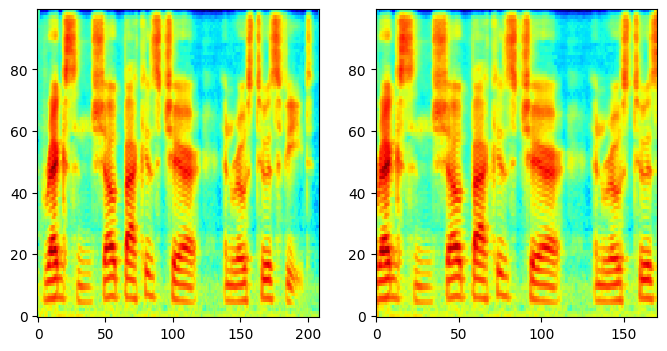

In [78]:
# import torchaudio
# from vocos.feature_extractors import MelSpectrogramFeatures
# from scipy.io.wavfile import write as write_wav

# fs = 16000
# melgen = MelSpectrogramFeatures(sample_rate=fs)
# def get_mel(path):
#     y, sr = torchaudio.load(path)
#     if fs!=sr:
#         if y.size(0) > 1:  # mix to mono
#             y = y.mean(dim=0, keepdim=True)
#         y = torchaudio.functional.resample(y, orig_freq=sr, new_freq=fs)
#     mel = melgen(y[0])
#     return mel

# speakers = ["ASI", "RRBI", "SVBI", "TNI"]
# spk = speakers[0]
# text_dir = "./SPAT/transliteration/"
# base_dir = f"/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/{spk}_allsamples/English/wav/"
# save_dir = f"/mntcephfs/data/audiow/shoinoue/Dataset/CosyVoice/{spk}/English/wav/"
# os.makedirs(save_dir, exist_ok=True)
# basenames = list(set([os.path.basename(a).split(".")[0][:-2] for a in glob.glob(base_dir+f"*.wav")]))
# basenames.sort()

# import matplotlib.pyplot as plt

# basename = basenames[11]
# audiofiles = glob.glob(base_dir+f"{basename}*.wav")
# path = audiofiles[1]

# fig = plt.figure(figsize=(8, 4))

# x = librosa.load(path, sr=16000)[0]
# write_wav("temp.wav", fs, x)
# mel = np.array(get_mel("temp.wav"))
# print(mel.shape)
# play_audio("temp.wav", 16000)
# plot_spectrogram(mel, fig, (1, 2, 1))

# trim_audio_and_save(path, trim_threshold_in_db=30)
# mel = np.array(get_mel("temp.wav"))
# print(mel.shape)
# play_audio("temp.wav", fs)
# plot_spectrogram(mel, fig, (1, 2, 2))